In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../Data/accident_data.csv')

/Users/mattlampl/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (19,20,73,77,78,79,80,81,82,83,84,183,189) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
location_data = data.dropna(subset=['LONGITUDE', 'LATITUDE'])

In [4]:
geometry = geometry = [Point(xy) for xy in zip(location_data['DEC_LONG'], location_data['DEC_LAT'])]
location_gdf = gpd.GeoDataFrame(location_data, geometry=geometry, crs='EPSG:4326')

In [5]:
# Import the roads file
roads = gpd.read_file('alleghenycounty_streetcenterlines202303.zip', crs="EPSG:4326")

In [6]:
acc_road_join = gpd.sjoin_nearest(location_gdf.to_crs(roads.crs), roads, how='left')

In [7]:
acc_road_join['FATAL']

1         0
2         0
6         0
11        0
14        0
         ..
216619    0
216620    0
216621    0
216622    0
216623    0
Name: FATAL, Length: 206662, dtype: int64

In [8]:
acc_road_agg = acc_road_join.groupby('FULL_NAME').agg({'CRASH_CRN':'count', 
                                                       'FATAL':'sum', 'INJURY':'sum',
                                                       'FATAL_OR_MAJ_INJ':'sum'})\
    .reset_index()\
    .rename(columns={'FULL_NAME':'STREET', 'CRASH_CRN':'COUNT', 
                     'FATAL':'NUM_FATAL', 'INJURY':'NUM_INJURY',
                     'FATAL_OR_MAJ_INJ':'NUM_FATAL_OR_MAJ_INJ'})\
    .sort_values('COUNT', ascending=False)

In [9]:
acc_road_agg['PCT_FATAL'] = acc_road_agg['NUM_FATAL'] / acc_road_agg['COUNT']
acc_road_agg['PCT_INJURY'] = acc_road_agg['NUM_INJURY'] / acc_road_agg['COUNT']
acc_road_agg['PCT_FATAL_OR_MAJ_INJ'] = acc_road_agg['NUM_FATAL_OR_MAJ_INJ'] / acc_road_agg['COUNT']
acc_road_agg.head(20)

,STREET,COUNT,NUM_FATAL,NUM_INJURY,NUM_FATAL_OR_MAJ_INJ,PCT_FATAL,PCT_INJURY,PCT_FATAL_OR_MAJ_INJ
3163,I376 EB,6808,27,2996,114,0.003966,0.440071,0.016745
3198,I376 WB,5966,27,2625,118,0.004526,0.439993,0.019779
5977,SAW MILL RUN BLVD,3045,15,1344,74,0.004926,0.441379,0.024302
4907,OHIO RIVER BLVD,2684,22,1158,92,0.008197,0.431446,0.034277
5221,PERRY HWY,2583,15,1145,47,0.005807,0.443283,0.018196
73,5TH AVE,2579,11,1223,73,0.004265,0.474215,0.028306
6329,STATE ROUTE 28 NB,2259,19,790,60,0.008411,0.349712,0.026560
6347,STATE ROUTE 28 SB,2248,22,796,50,0.009786,0.354093,0.022242
5195,PENN AVE,2073,10,959,55,0.004824,0.462615,0.026532
7226,WILLIAM PENN HWY,2057,9,1074,50,0.004375,0.522120,0.024307


In [10]:
road_acc_counts = roads.merge(acc_road_agg, how='inner', left_on='FULL_NAME', right_on='STREET')

In [11]:
def to_geojson():
    road_acc_counts.to_file('road_acc_counts.geojson', driver='GeoJSON')

# Plot Maps

In [12]:
allegheny_county = gpd.read_file('alcogisallegheny-county-boundary.zip', crs="EPSG:2272")
allegheny_county = allegheny_county.to_crs('EPSG:2272')

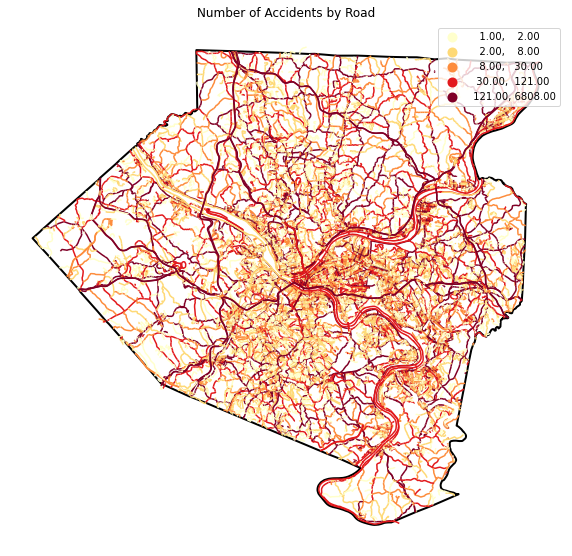

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
road_acc_counts.plot('COUNT', ax=ax, lw=1.5, scheme='quantiles', cmap='YlOrRd', legend=True)
allegheny_county.plot(ax=ax, facecolor='None', edgecolor='black', lw=2)
plt.axis('off')
plt.title('Number of Accidents by Road')
plt.show()

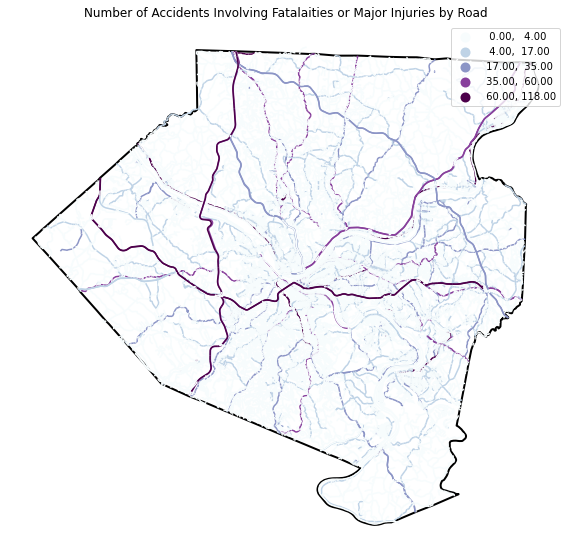

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
road_acc_counts.plot('NUM_FATAL_OR_MAJ_INJ', ax=ax, lw=1.5, scheme='naturalbreaks', cmap='BuPu', legend=True)
allegheny_county.plot(ax=ax, facecolor='None', edgecolor='black', lw=2)
plt.axis('off')
plt.title('Number of Accidents Involving Fatalaities or Major Injuries by Road')
plt.show()

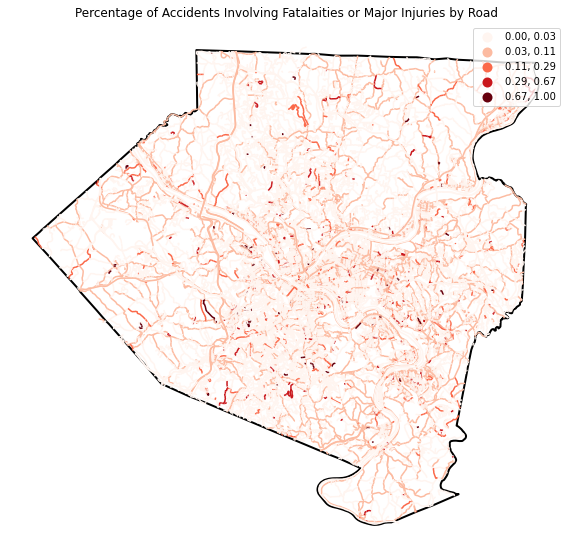

In [15]:
fig, ax = plt.subplots(figsize=(10,10))
road_acc_counts.plot('PCT_FATAL_OR_MAJ_INJ', ax=ax, lw=1.5, scheme='naturalbreaks', cmap='Reds', legend=True)
allegheny_county.plot(ax=ax, facecolor='None', edgecolor='black', lw=2)
plt.axis('off')
plt.title('Percentage of Accidents Involving Fatalaities or Major Injuries by Road')
plt.show()

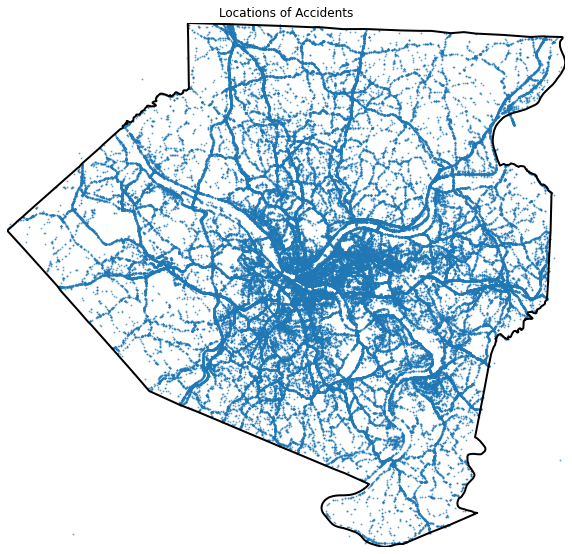

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
location_gdf.to_crs('EPSG:2272').plot(ax=ax, markersize=1, alpha=0.5)
allegheny_county.plot(ax=ax, facecolor='None', edgecolor='black', lw=2)
minx, miny, maxx, maxy = allegheny_county.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.axis('off')
plt.title('Locations of Accidents')
plt.show()

In [17]:
road_acc_counts.sort_values('NUM_FATAL_OR_MAJ_INJ', ascending=False)

,OBJECTID,FEATURE_KE,L_STREET_I,R_STREET_I,CAD_LLO,CAD_LHI,CAD_RLO,CAD_RHI,LLO,LHI,...,Shape_Leng,geometry,STREET,COUNT,NUM_FATAL,NUM_INJURY,NUM_FATAL_OR_MAJ_INJ,PCT_FATAL,PCT_INJURY,PCT_FATAL_OR_MAJ_INJ
59804,238062,92668,11630,11630,659,659,656,656,659,659,...,733.383271,"LINESTRING (1319775.747 401909.630, 1319787.00...",I376 WB,5966,27,2625,118,0.004526,0.439993,0.019779
59796,87618,87618,11627,11627,677,687,676,686,677,687,...,7161.391712,"LINESTRING (1331085.981 404365.078, 1331179.50...",I376 WB,5966,27,2625,118,0.004526,0.439993,0.019779
59798,88835,88835,11627,11627,689,695,688,694,689,695,...,3702.431825,"LINESTRING (1335340.610 408330.034, 1335350.50...",I376 WB,5966,27,2625,118,0.004526,0.439993,0.019779
59800,90285,90285,11629,11629,649,653,648,652,649,653,...,2375.909020,"LINESTRING (1315279.242 405142.050, 1315280.01...",I376 WB,5966,27,2625,118,0.004526,0.439993,0.019779
59801,90286,90286,11618,11618,655,657,654,654,655,657,...,3216.906755,"LINESTRING (1317348.747 403998.779, 1317351.74...",I376 WB,5966,27,2625,118,0.004526,0.439993,0.019779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30705,53697,53697,16220,16220,2299,2329,2300,2328,2299,2315,...,626.934546,"LINESTRING (1317325.000 375210.500, 1317320.00...",MORROW RD,21,0,7,0,0.000000,0.333333,0.000000
30706,54741,54741,16220,16220,2287,2293,0,0,2287,2293,...,309.819076,"LINESTRING (1317631.750 375254.000, 1317325.00...",MORROW RD,21,0,7,0,0.000000,0.333333,0.000000
30707,55253,55253,16219,16219,6001,6099,6000,6098,6069,6079,...,870.557052,"LINESTRING (1364640.208 491912.000, 1364578.70...",MORROW RD,21,0,7,0,0.000000,0.333333,0.000000
30708,83613,83613,16218,16218,0,0,0,0,0,0,...,59.583321,"LINESTRING (1379898.250 407422.750, 1379901.25...",MORROW RD,21,0,7,0,0.000000,0.333333,0.000000


In [18]:
road_acc_counts.to_file('road_acc_counts.geojson', driver='GeoJSON')